In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

# Load the dataset into a DataFrame
drone_data = pd.read_csv(r'/content/updated_drone_dataset_with_new_features.csv')

# Display the shape of the original DataFrame
print("Original DataFrame shape:", drone_data.shape)

# Select the first 4300 columns
selected_columns = drone_data.iloc[:, :4300]
print("Selected DataFrame shape:", selected_columns.shape)

# Define continuous and categorical features based on the selected columns
continuous_features = selected_columns.columns[:11].tolist()  # Assuming the first 11 are continuous features
categorical_features = selected_columns.columns[11:].tolist()  # Remaining are categorical features

# Convert all continuous features to numeric, coercing errors to NaN
for column in continuous_features:
    selected_columns[column] = pd.to_numeric(selected_columns[column], errors='coerce')

# Drop rows with NaN values resulting from conversion
selected_columns = selected_columns.dropna(subset=continuous_features)

# Normalize continuous features
scaler = StandardScaler()
selected_columns[continuous_features] = scaler.fit_transform(selected_columns[continuous_features])

# Encode categorical features
label_encoder = LabelEncoder()
for feature in categorical_features:
    selected_columns[feature] = label_encoder.fit_transform(selected_columns[feature])

# Split the data into features (X) and target label (Y)
X = selected_columns.drop('Intrusion_Attempts', axis=1)  # Ensure 'Intrusion_Attempts' exists
y = selected_columns['Intrusion_Attempts']                # Ensure 'Intrusion_Attempts' exists

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Isolation Forest for anomaly detection
isolation_forest = IsolationForest(contamination=0.02, random_state=42)
isolation_forest.fit(X_train)  # Fit the model

# Now you can proceed with predictions or other analysis
y_pred_anomalies = isolation_forest.predict(X_test)

# Display prediction results
print("Anomaly Predictions:", y_pred_anomalies)


Original DataFrame shape: (17328, 43)
Selected DataFrame shape: (17328, 43)
Anomaly Predictions: [ 1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1

In [3]:
import numpy as np
# Count anomalies and normal instances in the predictions
unique, counts = np.unique(y_pred_anomalies, return_counts=True)
anomaly_counts = dict(zip(unique, counts))
print(f"Anomalies and Normal Instances: {anomaly_counts}")

Anomalies and Normal Instances: {-1: 26, 1: 851}


In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Check if ground truth labels (y_test) for anomalies exist
if 'y_test' in locals():  # Assuming y_test has actual labels
    print("Accuracy:", accuracy_score(y_test, y_pred_anomalies))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_anomalies))
    print("Classification Report:\n", classification_report(y_test, y_pred_anomalies))


Accuracy: 0.9486887115165337
Confusion Matrix:
 [[  0   0   0]
 [  1   0  19]
 [ 25   0 832]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00        20
           1       0.98      0.97      0.97       857

    accuracy                           0.95       877
   macro avg       0.33      0.32      0.32       877
weighted avg       0.96      0.95      0.95       877



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [5]:
# Try different contamination levels
for contamination in [0.01, 0.02, 0.05]:
    isolation_forest = IsolationForest(contamination=contamination, random_state=42)
    isolation_forest.fit(X_train)
    y_pred_anomalies = isolation_forest.predict(X_test)
    print(f"Contamination: {contamination}")
    if 'y_test' in locals():
        print("Accuracy:", accuracy_score(y_test, y_pred_anomalies))

Contamination: 0.01
Accuracy: 0.9600912200684151
Contamination: 0.02
Accuracy: 0.9486887115165337
Contamination: 0.05
Accuracy: 0.9304446978335233


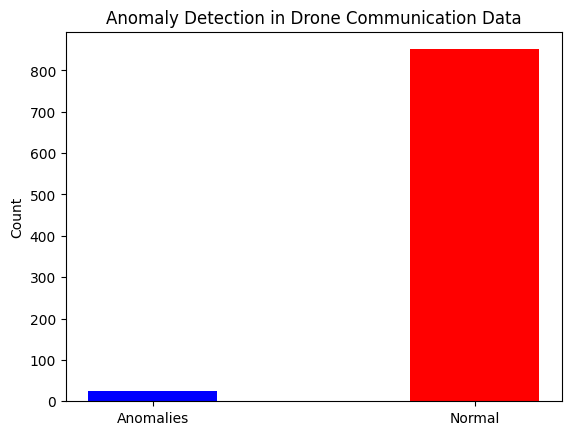

In [6]:
import matplotlib.pyplot as plt

# Visualizing the anomaly predictions
plt.bar(anomaly_counts.keys(), anomaly_counts.values(), color=['blue', 'red'])
plt.xticks([1, -1], ['Normal', 'Anomalies'])
plt.ylabel('Count')
plt.title('Anomaly Detection in Drone Communication Data')
plt.show()

In [7]:
# Example of logging anomalies
anomalies = X_test[y_pred_anomalies == -1]
anomalies.to_csv("detected_anomalies.csv", index=False)
print("Anomalies logged.")


Anomalies logged.


In [8]:
import time
import numpy as np

# Function to simulate real-time monitoring
def real_time_monitoring(data_chunk, model):
    # Predict anomalies on the new data chunk
    predictions = model.predict(data_chunk)
    anomalies = np.where(predictions == -1)[0]  # Get anomaly indices
    return anomalies

# Simulate real-time data stream
batch_size = 100  # Define the size of each data batch
for i in range(0, len(X_test), batch_size):
    data_chunk = X_test[i:i+batch_size]
    anomalies = real_time_monitoring(data_chunk, isolation_forest)

    if len(anomalies) > 0:
        print(f"Anomalies detected in batch {i // batch_size + 1}: {anomalies}")
        # Trigger alert or log the anomaly
        # Example: Save anomalies to a CSV file
        data_chunk.iloc[anomalies].to_csv(f"anomalies_batch_{i // batch_size + 1}.csv", index=False)

    time.sleep(1)  # Simulate delay between data batches


Anomalies detected in batch 1: [11 35 55 71 90]
Anomalies detected in batch 2: [17 31 55 60 66 88]
Anomalies detected in batch 3: [3]
Anomalies detected in batch 4: [71 82 89]
Anomalies detected in batch 5: [27 40 46 62 66]
Anomalies detected in batch 6: [ 7 41 55 60 69 75 78 79]
Anomalies detected in batch 7: [25 31 37 56 59 68 75]
Anomalies detected in batch 8: [13 18 86]
Anomalies detected in batch 9: [ 6 11 24 52 60]


In [9]:
pip install keras

In [10]:
from keras.models import Sequential
from keras.layers import Dense

# Build a simple neural network for binary classification (intrusion detection)
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# Evaluate the model on test data
accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

# Make predictions on the test set (anomalies are marked as 1 or 0)
y_pred = model.predict(X_test)



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9670 - loss: 23.9095
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9635 - loss: 6.6849
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9774 - loss: 4.3477
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9654 - loss: 4.1760
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9727 - loss: 4.6954
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9691 - loss: 2.6506
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9789 - loss: 1.8547
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9757 - loss: 1.8018
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9709 - loss: 1.8449
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9622 - loss: 1.7254
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9699 - loss: 5.0565  
Accuracy: [4.479558944702148, 0.973774254322052]
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [11]:
# Simulate multiple drones with their own anomaly detection models
num_drones = 5
drone_models = [IsolationForest(contamination=0.02, random_state=i) for i in range(num_drones)]

# Each drone trains its own model
for drone_model in drone_models:
    drone_model.fit(X_train)

# Function to simulate collaborative anomaly detection
def collaborative_anomaly_detection(test_data, models):
    votes = np.zeros(len(test_data))

    for model in models:
        # Each drone gives its prediction (-1 for anomaly, 1 for normal)
        predictions = model.predict(test_data)
        votes += predictions  # Sum up the votes

    # Majority voting: if more than half drones vote -1, it's an anomaly
    final_predictions = np.where(votes < 0, -1, 1)

    return final_predictions

# Run the collaboration-based anomaly detection on the test set
collaborative_predictions = collaborative_anomaly_detection(X_test, drone_models)
print(f"Collaborative Anomaly Detection Results: {collaborative_predictions}")


Collaborative Anomaly Detection Results: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 

In [12]:
import logging

# Setup logging
logging.basicConfig(filename='intrusion_alerts.log', level=logging.INFO)

# Trigger alert for detected anomalies
def trigger_alert(anomalies):
    if len(anomalies) > 0:
        logging.info(f"Anomalies detected: {anomalies}")
        print("ALERT: Anomalies detected. Action required!")
        # Example: Shut down the affected drone or redirect communication
        # Implement your specific countermeasures here

# Example: Trigger alert for anomalies detected during real-time monitoring
for i in range(0, len(X_test), batch_size):
    data_chunk = X_test[i:i+batch_size]
    anomalies = real_time_monitoring(data_chunk, isolation_forest)
    trigger_alert(anomalies)


ALERT: Anomalies detected. Action required!
ALERT: Anomalies detected. Action required!
ALERT: Anomalies detected. Action required!
ALERT: Anomalies detected. Action required!
ALERT: Anomalies detected. Action required!
ALERT: Anomalies detected. Action required!
ALERT: Anomalies detected. Action required!
ALERT: Anomalies detected. Action required!
ALERT: Anomalies detected. Action required!
